In [23]:
%matplotlib inline

import librosa
import numpy as np
import pylab as pl
import os

from sklearn.cluster import MeanShift, estimate_bandwidth  
from sklearn.cluster import KMeans

from utils import ZCA, wav2audio_segment, Descriptor, audiofigure, normalize

from sklearn import manifold 

import pandas as pd
from pandas.tools.plotting import scatter_matrix




Choose a WAV mono file, and set the frame size (NFFT) and hop, and other parameters

In [24]:
path = "../wavs/"
fnames = os.listdir(path)
fnames = ["Xenakis_Metastasis.wav"]
fnames = ["Stockhausen_Kontakte.wav"]
fnames = ["Grisey_partiels.wav"]

sr = 44100

cqt_n_bins = 60 * 2     
n_mfcc = 20
NFFT = 2**12
HOP = NFFT/2

T1 = 0
T2 = 800


Add descriptors

In [25]:
DESCRIPTORS = [

{'name': 'mfcc',
 'params': {'n_mfcc':n_mfcc,'sr':sr,"n_fft":NFFT, "hop_length":HOP},
 'function': lambda self,y: librosa.feature.mfcc(S=Sm, **self.params).T },
    
{'name': 'scontrast',
 'params': {'sr':sr,"n_fft":NFFT, "hop_length":HOP} ,
 'function' : lambda self,y: librosa.feature.spectral_contrast(S=Sm, **self.params).T },

{'name': 'chroma',
 'params':{'n_fft':NFFT,'hop_length':HOP} ,
 'function': lambda self, y: librosa.feature.chroma_stft(S=Sm, **self.params).T }]

Compute descriptors

In [26]:
audio = {}
df = pd.DataFrame()

for fname in fnames:
    sr, signal  = wav2audio_segment(path+fname,T1,T2)

    S = librosa.stft(signal,n_fft=NFFT, hop_length=HOP)
    Sm = abs(S)
    
    ntotal = signal.size
    durtotal = ntotal/sr
    
    data = []
    multiindex = []
    
    for D in DESCRIPTORS:
        d = Descriptor(D)
        d.perform(signal)
        data.append(normalize(d.data,0))
            
        multiindex += [ (d.name,i) for i in range(d.data.shape[1]) ]
    

/usr/local/lib/python3.4/dist-packages/scipy/io/wavfile.py:267: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)
/usr/local/lib/python3.4/dist-packages/numpy/core/numeric.py:482: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return array(a, dtype, copy=False, order=order)


In [27]:
columns = pd.MultiIndex.from_tuples(multiindex, names=['Descriptor', 'Feature'])
df = pd.DataFrame(np.hstack(data),columns = columns)
df.shape

(9424, 39)

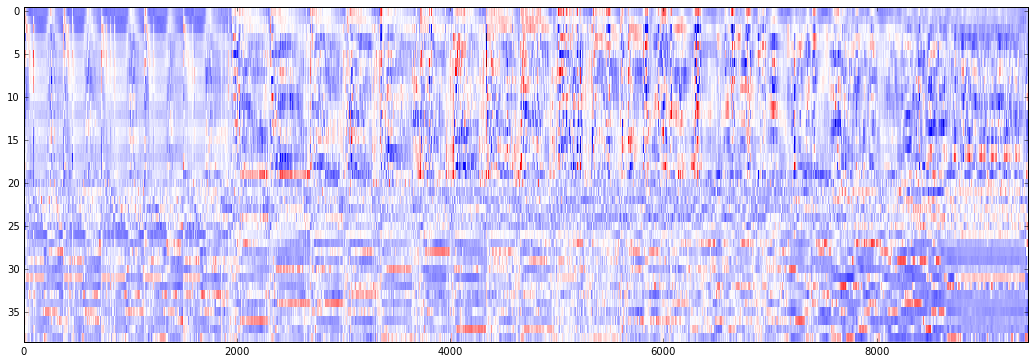

In [28]:
pl.figure(figsize=(18,6))
pl.imshow(df.T,aspect='auto',interpolation='none',cmap=pl.cm.seismic);

Similarity matrix (recurrence matrix)

In [29]:
# rec = librosa.segment.recurrence_matrix(df.values.T,k=1120,metric='euclidean',sym=True,mode='distance')
# pl.figure(figsize=(18,18))
# pl.imshow(rec, aspect= 'auto', interpolation = 'none');


Clustering, trying DBSCAN, not working fine

In [30]:
# from sklearn.cluster import DBSCAN
# from sklearn import metrics

# db = DBSCAN(eps=.8, min_samples=10, n_jobs=4).fit(df.values)
# labels = db.labels_

# print("Silhouette Coefficient: %0.3f"% metrics.silhouette_score(df.values, labels))

# pl.plot(labels)
# pl.ylim(-2,1)

PCA descomposition to 3 componentes, scatter matrix visualization

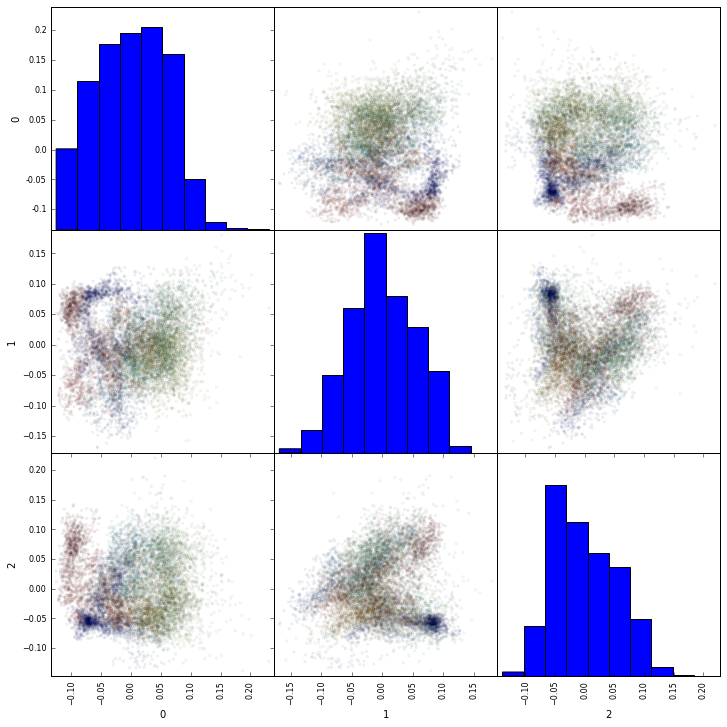

In [31]:
%matplotlib inline

from sklearn import decomposition

pca = decomposition.PCA(n_components=3)
Y = pca.fit_transform(df.values)
time_color = pl.cm.jet(np.linspace(0,1,Y.shape[0]))

scatter_matrix(pd.DataFrame(Y), alpha=0.05, figsize=(12, 12), c=time_color);



In [35]:
audio_path = path + fname
duration = 120
ix = sr*duration/HOP+sr/NFFT
Y2 = Y[:ix,:]
audiofigure(Y2, audio_path, sr=sr/HOP, fps=4, ylim=(-0.2,0.2), figsize=(14,6))

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


MDS too much memory 

In [12]:
# mds = manifold.MDS(n_components=2, max_iter=1000, eps=1e-3, n_jobs=4)
# Y = mds.fit(df.values).embedding_
# pl.scatter(Y[:, 0], Y[:, 1],c=time_color,alpha=0.2, edgecolors='none');

<IPython.core.display.Javascript object>


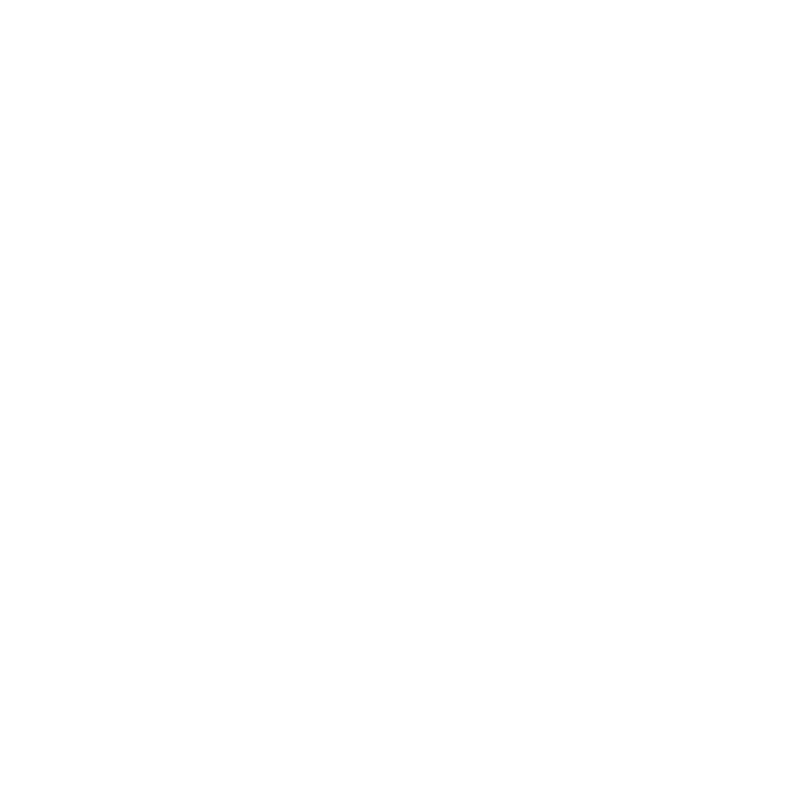

<IPython.core.display.Javascript object>


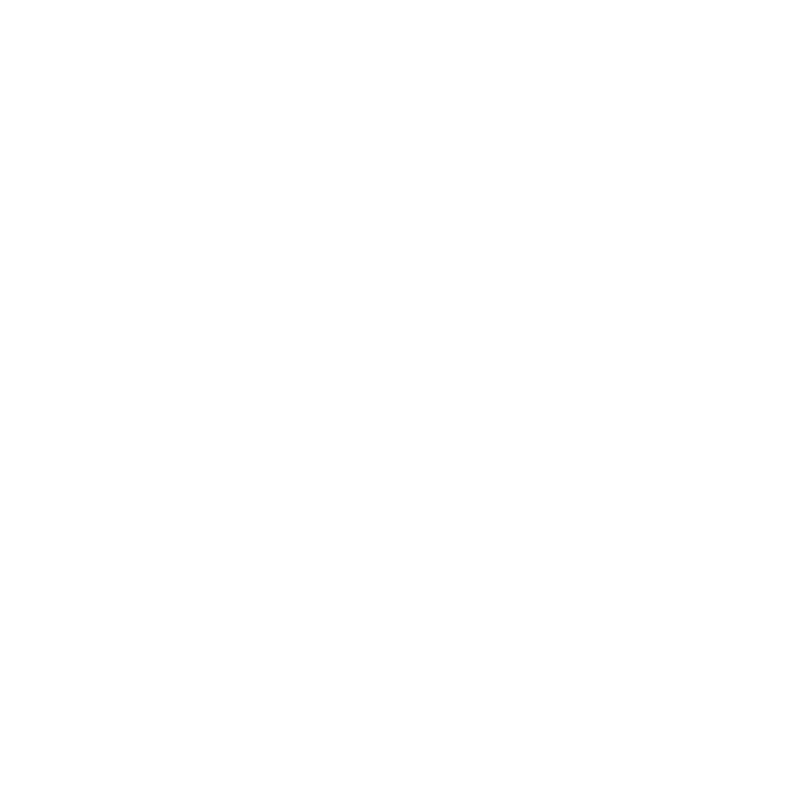

In [20]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
fig = pl.figure(figsize=(10,10))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

time_color = pl.cm.jet(np.linspace(0,1,Y.shape[0]))
ax.scatter(Y[:, 0], Y[:, 1], Y[:,2],c=time_color,alpha=0.2, edgecolors='none');